In [1]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize #tranform JSON file into a pandas dataframe
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim #convert an address into latitude and longitude values
from sklearn.cluster import KMeans

### 1. Read Toronto postcodes and coordinates table prepared previously in part 2 of assignment.

In [2]:
df = pd.read_csv('Toronto_Postcodes_Coordinates.csv', index_col=0)
df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### Select only boroughs that contain the word Toronto.

In [3]:
df_Toronto = df[df['Borough'].str.contains('Toronto')]
df_Toronto.reset_index(drop=True, inplace=True)
df_Toronto

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


In [4]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The latitude and longitude of Toronto are {}, {}.'.format(latitude, longitude))

The latitude and longitude of Toronto are 43.653963, -79.387207.


In [5]:
#Create map of 37 boroughs in Toronto that have the word Toronto.
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

#Add markers to map
for lat, lng, borough, neighborhood in zip(df_Toronto['Latitude'], df_Toronto['Longitude'], df_Toronto['Borough'], df_Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)
map_Toronto

In [28]:
map_Toronto.save('map_Toronto.html')

Populating the interactive namespace from numpy and matplotlib


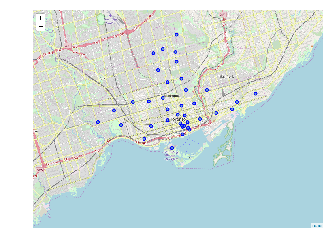

In [75]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('map_Toronto.png')
#imgplot = plt.imshow(img)
plt.imshow(img)
plt.axis('off')
plt.show()

#### Define Foursquare credentials and version

In [6]:
# @hidden_cell
CLIENT_ID = 'LVS24FQQQ3FXAJR20XJOCR4GKZ4DDSGM2YCBNVHKJYAMMGVY'
CLIENT_SECRET = '1Z0F5IENHNOTS2HTT3OZY3DUR1OPMPATVCKGFHQRREACXF0I'
VERSION = '20190525'
print('Foursquare ceredentials are defined but hidden')

Foursquare ceredentials are defined but hidden


In [7]:
#Function that extracts the category of the venue.
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 2. Explore neighborhoods in Toronto

In [8]:
#Function to explore all the neighborhoods.
def getNearbyVenues(names, latitudes, longitudes, LIMIT=100, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
Toronto_venues = getNearbyVenues(names=df_Toronto['Neighbourhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [10]:
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
3,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
4,"The Danforth West, Riverdale",43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop


In [11]:
#Check the number of returned venues per neighborhood.
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",21,21,21,21,21,21
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",15,15,15,15,15,15
"Cabbagetown, St. James Town",47,47,47,47,47,47
Central Bay Street,88,88,88,88,88,88
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,16,16,16,16,16,16


In [12]:
#Number of unique categories in all returned venues.
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 242 uniques categories.


## 3. Analyze each neighborhood

In [13]:
#One hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#Add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

#Move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
Toronto_onehot.shape

(1692, 242)

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [15]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.00,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.00
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.000000,0.066667,0.066667,0.066667,0.133333,0.2,0.133333,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Central Bay Street,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.00,0.011364,0.000000,0.011364,0.000000,0.011364,0.000000,0.00
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.010000,0.00000,0.00,0.060000,0.000000,0.000000,0.030000,0.010000,0.000000,0.00
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Church and Wellesley,0.011494,0.011494,0.011494,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.00,0.000000,0.011494,0.000000,0.011494,0.000000,0.011494,0.00


In [16]:
Toronto_grouped.shape

(38, 242)

#### Print each neighborhood along with the top 5 most common venues

In [17]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2  American Restaurant  0.04
3           Steakhouse  0.04
4                  Bar  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2          Steakhouse  0.04
3  Italian Restaurant  0.04
4            Beer Bar  0.04


----Brockton, Exhibition Place, Parkdale Village----
                   venue  freq
0         Breakfast Spot  0.10
1                   Café  0.10
2  Performing Arts Venue  0.10
3            Coffee Shop  0.10
4          Grocery Store  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.12
1         Yoga Studio  0.06
2    Recording Studio  0.06
3         Pizza Place  0.06
4                 Spa  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              ven

In [18]:
#Function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
#Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,American Restaurant,Hotel,Burger Joint,Bakery,Cosmetics Shop
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Cheese Shop,Café,Steakhouse,Restaurant,Italian Restaurant,Bakery,Seafood Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Performing Arts Venue,Coffee Shop,Café,Breakfast Spot,Convenience Store,Bar,Caribbean Restaurant,Pet Store,Stadium,Gym
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio,Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Plane,Harbor / Marina,Boutique,Airport,Airport Food Court,Airport Gate,Boat or Ferry
5,"Cabbagetown, St. James Town",Coffee Shop,Park,Chinese Restaurant,Pub,Pizza Place,Italian Restaurant,Restaurant,Bakery,Café,Caribbean Restaurant
6,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Chinese Restaurant,Burger Joint,Spa,Sushi Restaurant,Sandwich Place,Middle Eastern Restaurant,Bakery
7,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bar,Bakery,Dumpling Restaurant,Coffee Shop,Vietnamese Restaurant,Chinese Restaurant,Grocery Store
8,Christie,Café,Grocery Store,Park,Convenience Store,Nightclub,Baby Store,Restaurant,Diner,Athletics & Sports,Italian Restaurant
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Men's Store,Pub,Bubble Tea Shop,Burger Joint,Hotel


## 4. Cluster neighborhoods

In [20]:
#Run k-means to cluster the neighborhood into 5 clusters.

kclusters = 5 #Number of clusters
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0], dtype=int32)

In [21]:
#Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Toronto_merged = df_Toronto
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood.
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Health Food Store,Pub,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Bookstore,Brewery,Bubble Tea Shop,Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Pizza Place,Gym,Intersection,Pet Store,Movie Theater,Pub,Burrito Place,Sandwich Place,Burger Joint,Brewery
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Bakery,Italian Restaurant,American Restaurant,Middle Eastern Restaurant,Latin American Restaurant,Fish Market,Bookstore
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Lake,Swim School,Bus Line,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


In [22]:
#Visualize clusters on the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [54]:
map_clusters.save('map_clusters.html')

## 5. Examine clusters

#### Cluster 1

In [23]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East Toronto,"The Danforth West, Riverdale",0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Bookstore,Brewery,Bubble Tea Shop,Restaurant
2,East Toronto,"The Beaches West, India Bazaar",0,Pizza Place,Gym,Intersection,Pet Store,Movie Theater,Pub,Burrito Place,Sandwich Place,Burger Joint,Brewery
3,East Toronto,Studio District,0,Café,Coffee Shop,Gastropub,Bakery,Italian Restaurant,American Restaurant,Middle Eastern Restaurant,Latin American Restaurant,Fish Market,Bookstore
4,Central Toronto,Lawrence Park,0,Park,Lake,Swim School,Bus Line,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
6,Central Toronto,North Toronto West,0,Coffee Shop,Yoga Studio,Rental Car Location,Park,Fast Food Restaurant,Spa,Sporting Goods Shop,Mexican Restaurant,Miscellaneous Shop,Salon / Barbershop
7,Central Toronto,Davisville,0,Dessert Shop,Sandwich Place,Café,Italian Restaurant,Coffee Shop,Pizza Place,Sushi Restaurant,Restaurant,Brewery,Japanese Restaurant
9,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",0,Coffee Shop,Pub,Pizza Place,Sports Bar,Sushi Restaurant,Fried Chicken Joint,Bagel Shop,Athletics & Sports,American Restaurant,Light Rail Station
11,Downtown Toronto,"Cabbagetown, St. James Town",0,Coffee Shop,Park,Chinese Restaurant,Pub,Pizza Place,Italian Restaurant,Restaurant,Bakery,Café,Caribbean Restaurant
12,Downtown Toronto,Church and Wellesley,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Men's Store,Pub,Bubble Tea Shop,Burger Joint,Hotel
13,Downtown Toronto,"Harbourfront, Regent Park",0,Coffee Shop,Park,Bakery,Pub,Theater,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Shoe Store


#### Cluster 2

In [24]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,Roselawn,1,Garden,Women's Store,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 3

In [25]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,"Moore Park, Summerhill East",2,Restaurant,Playground,Gym,Trail,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
10,Downtown Toronto,Rosedale,2,Park,Trail,Playground,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Women's Store
23,Central Toronto,"Forest Hill North, Forest Hill West",2,Trail,Jewelry Store,Sushi Restaurant,Park,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Women's Store


#### Cluster 4

In [26]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,The Beaches,3,Health Food Store,Pub,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 5

In [27]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + [2] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Central Toronto,Davisville North,4,Clothing Store,Sandwich Place,Gym,Park,Breakfast Spot,Hotel,Food & Drink Shop,Eastern European Restaurant,Doner Restaurant,Donut Shop
